TASK#01

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2

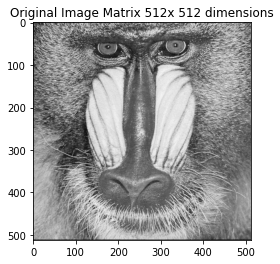

In [ ]:
# Reference Image
imagec = cv2.imread('/content/drive/MyDrive/Colab Notebooks/babbon_grey.bmp')# My reference Image
image=np.dot(imagec[...,:3], [0.2989, 0.5870, 0.1140])
row,col= image.shape
plt.title("Original Image Matrix %1.0f" %row + "x %1.0f" %col+" dimensions" )
plt.imshow(image,cmap=plt.get_cmap('gray'))

In [ ]:
def gauss_kernel(size, sigma):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    gnormal =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return gnormal


# Defining a filter

def filter(image, kernel):

    # Convolution with vertical mask
    kernel = np.flipud(np.fliplr(kernel))

    x_K = kernel.shape[0] 
    y_K = kernel.shape[1] 
    x_I = image.shape[0] 
    y_I = image.shape[1]
    x_O = int(x_I -x_K  + 1)
    y_O = int(y_I -y_K + 1)
    output = np.zeros((x_O, y_O))
    for i in range(y_O):
        for j in range(x_O):
            output[j][i] = (kernel * image[j: j + x_K, i: i + y_K]).sum()


    return output
  
 

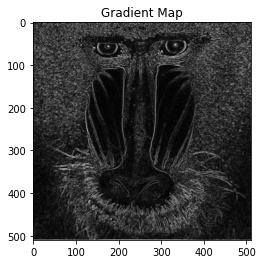

In [ ]:
# Denoising of image using Gaussian blur, as edge detection is sensitive to noise
kernel=gauss_kernel(10,1);
image_g=filter(image,kernel)

# Defining vertical Sobel Mask
kernel_vert = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)

#Defining horizonatal Sobel Mask
kernel_horz = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)


# Applying vertical Sobel Mask
kernel=kernel_vert
new_image_sobel_Y=filter(image,kernel)


# Applying vertical Sobel Mask
kernel=kernel_horz
new_image_sobel_X=filter(image,kernel)

# Gradiant Map
gradient_mag = np.sqrt(np.square(new_image_sobel_X) + np.square(new_image_sobel_Y))
gradient_mag *= 255.0 / gradient_mag.max()


plt.imshow(gradient_mag, cmap='gray')
plt.title("Gradient Map")
plt.show()

In [ ]:
# Edge Strength Map via non-maximum supression

def non_max_suppression(image, theta_mag):
    M, N = image.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = theta_mag * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
                q = 255
                r = 255
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = image[i, j+1]
                    r = image[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = image[i+1, j-1]
                    r = image[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = image[i+1, j]
                    r = image[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = image[i-1, j-1]
                    r = image[i+1, j+1]

                if (image[i,j] >= q) and (image[i,j] >= r):
                    Z[i,j] = image[i,j]
                else:
                    Z[i,j] = 0
    return Z

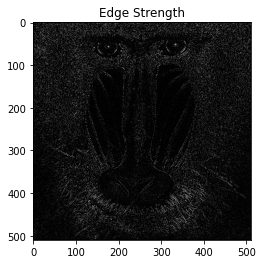

In [ ]:
theta_mag = np.arctan2(new_image_sobel_Y, new_image_sobel_X)
edge_strength=non_max_suppression(gradient_mag,theta_mag)

plt.imshow(edge_strength, cmap='gray')
plt.title("Edge Strength")
plt.show()

In [ ]:
# Edge orientation map--> defining types of edges based on proximity to two thresholds

def thresholder(image, lowThreshold, highThreshold):
    
    
    M, N = image.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    #saturation limits
    weak = np.int32(2)
    strong = np.int32(255)
    
    # finding threshold regions
    strong_i, strong_j = np.where(image >= highThreshold)
    
    weak_i, weak_j = np.where((image <= highThreshold) & (image >= lowThreshold))
    
    #thresholding
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res,weak,strong)

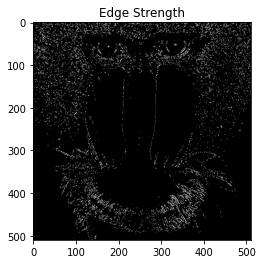

In [ ]:
thresholded_image,weak,strong=thresholder(edge_strength,30,100)

plt.imshow(thresholded_image,
 cmap='gray')
plt.title("Edge Strength")
plt.show()

In [ ]:
# Compensation for weak pixels
def hysteresis(image, weak, strong):
    M, N = image.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (image[i,j] == weak):
                    if ((image[i+1, j-1] == strong) or (image[i+1, j] == strong) or (image[i+1, j+1] == strong)
                        or (image[i, j-1] == strong) or (image[i, j+1] == strong)
                        or (image[i-1, j-1] == strong) or (image[i-1, j] == strong) or (image[i-1, j+1] == strong)):
                        image[i, j] = strong
                    else:
                        image[i, j] = 0
    return image

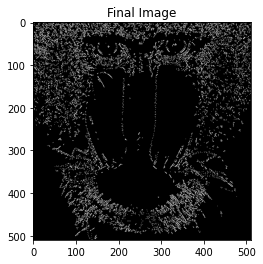

In [ ]:
final_image=hysteresis(thresholded_image,weak,strong)

plt.imshow(final_image,cmap='gray')
plt.title("Final Image")
plt.show()

Task#02

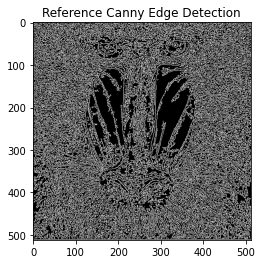

In [ ]:

edges_canny = cv2.Canny(imagec, 30, 100)
plt.imshow((edges_canny),cmap='gray')
plt.title("Reference Canny Edge Detection")
plt.show()

Task#03

In [ ]:

def BiLinear_interpolation(img,scale):
    scrH,scrW=img.shape
    dstH=scrH*scale
    dstW=scrW*scale
    img=np.pad(img,((0,1),(0,1)),'constant')
    retimg=np.zeros((dstH,dstW),dtype=np.uint8)
    for i in range(dstH):
        for j in range(dstW):
            scrx=(i+1)*(scrH/dstH)-1
            scry=(j+1)*(scrW/dstW)-1
            x=math.floor(scrx)
            y=math.floor(scry)
            u=scrx-x
            v=scry-y
            retimg[i,j]=(1-u)*(1-v)*img[x,y]+u*(1-v)*img[x+1,y]+(1-u)*v*img[x,y+1]+u*v*img[x+1,y+1]
    return retimg

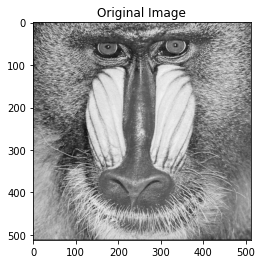

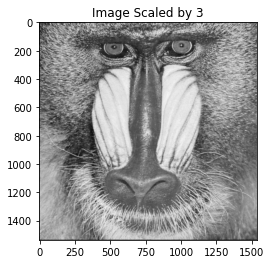

In [ ]:
scale=3
xx=BiLinear_interpolation(image,scale)

plt.figure()
plt.imshow(image,cmap='gray')
plt.title("Original Image")
plt.show()

plt.figure()
plt.imshow(xx,cmap='gray')
plt.title("Image Scaled by %1.0f" %scale)
plt.show()

Task#04

In [ ]:
imagec = cv2.imread('/content/drive/MyDrive/Colab Notebooks/babbon.bmp')# My reference Image
transformer=np.array([[3, 0, 0], [1, 1, 0], [0.001, 0, 1]])
M, N = image.shape
new_image= np.zeros((M,N))
new_image= new_image.astype(image.dtype)

for i in range(N-1):
    for j in range(M-1):
        x= np.array([i,j,1])
        y=transformer.dot(x)
        x_new=math.floor(y[0])
        y_new=math.floor(y[1])
        if 0<=x_new<=M-1 and 0<=y_new<=N-1:
          new_image[j,i]=image[y_new,x_new]
        

plt.figure()
plt.imshow(new_image,cmap='gray')
plt.title("Transformed Image")
plt.show()

NameError: ignored